In [1]:

from astropy.io import fits
import astropy.io.ascii # separate to not overwrite namespace 
from astropy.table import Column
from astropy import units as u
from scipy import optimize
from os.path import expanduser
# from ROOT import TRolke

%pylab inline
#%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
home = expanduser("~")
gc_dir = home + "/Dropbox/GalacticCenter/"


In [124]:
erg2TeV = (u.erg).to(u.TeV)
print(erg2TeV)

pylab.rcParams['figure.figsize'] = (12.0, 6.0)
#matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)


0.624150934326018


In [170]:
# define our line fitting function
fitfunc = lambda p, x: p[0] + p[1] * (x)
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

# define our () fitting function
fitfuncECPL = lambda p, x: p[0] + p[1] * np.log(x) - (x) / p[2] # np.log is natural log  
errfuncECPL = lambda p, x, y, err: (np.log(y) - fitfuncECPL(p, x)) / (err)

fitfuncECPL_CF = lambda N0, gamma, beta, E: N0 + gamma*E - 1.*np.exp(E) / beta 


#these are just copied from http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/python_tutorial.html
f = lambda E, N0, E0, gamma: N0*(E/E0)**(-1.*gamma)
ferr = lambda E, F, N0, N0err, E0, cov_gg: \
                F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)

f_ecpl = lambda E,N0,E0,gamma,beta: N0*(E/E0)**(-1.*gamma)*np.exp(-1.*E/beta)
ferr_ecpl = lambda E, F, N0, N0err, E0, cov_gg, b, cov_bb: \
            F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2) * cov_gg + (E/E0)**2 / b**4 * cov_bb)

def plotPythonFit(energy, flux, flux_err_arg, color, name, ECPL=False, E0=1.)#, power=0.):
    """fit flux points to a curve then plot
    by default it's labeled in units of TeV, and flux / m^2
    fluxes are multiplied by E^power """
    
    if isinstance(flux_err_arg, tuple):
        flux_err = (flux_err_arg[1] + flux_err_arg[0]) / 2 
    else:
        flux_err = flux_err_arg 

    if ECPL:
        pinit = [-26, -2.25, 10]
        out = optimize.leastsq(errfuncECPL, pinit,
                               args=(energy/E0, flux, flux_err / flux), 
                               full_output=1)

    else:
        logx = np.log(energy/E0)
        logy = np.log(flux)
        logyerr = np.log(flux_err)

        pinit = [-26, -2.25] # nb ln
    
        out = optimize.leastsq(errfunc, pinit,
                               args=(logx, logy, logyerr), 
                               full_output=1)
    # end if else ECPL 

    pfinal = out[0]
    covar  = out[1]
    print("parameters:")
    print(pfinal)
    print("covariance matrix")
    print(covar)
    
    N0    = np.exp(pfinal[0])
    gamma = pfinal[1]
    E     = np.linspace(energy[0], energy[-1], num=100)
    
    if ECPL:
        beta = pfinal[2]
        
        F    = f_ecpl(E, N0, E0, -1.*gamma, beta)
        chi2 = np.sum((flux - f_ecpl(energy, N0, E0, -1.*gamma, beta))**2/flux_err**2) / (len(energy) - 3)
        print("chi^2: "+str(chi2)+'\n')
        beta_err  = np.sqrt( covar[2][2] ) * chi2 #* N0  
        gamma_err = np.sqrt( covar[0][0] ) * chi2
        N0_err    = np.sqrt( covar[1][1] ) * N0 * chi2
        cov_gg = gamma_err**2
        cov_bb = beta_err**2
        Ferr = ferr_ecpl(E, F, N0, N0_err, E0, cov_gg, beta, cov_bb)

        fitTitle = (name + ' - N0: {0:.2e} +- {2:.2e}, '\
                    'G: {1:.2f} +- {3:.2f}, '\
                    'Ec: {4:.2f} +- {5:.2f}, '
                    'E0: {6:.0f}').format(float(N0), float(gamma),
                                          float(N0_err), float(gamma_err),
                                          float(beta), float(beta_err), float(E0))

    else:
        F    = f(E, N0, E0, -1.*gamma)
        chi2 = np.sum((flux - f(energy, N0, E0, -1.*gamma))**2 / flux_err**2) / (len(energy) - 2)
        print(chi2)
        gamma_err = np.sqrt( covar[0][0] ) * chi2
        N0_err    = np.sqrt( covar[1][1] ) * N0 * chi2
        cov_gg = gamma_err**2
        Ferr = ferr(E, F, N0, N0_err, E0, cov_gg)
        
        fitTitle = (name + ' - N0: {0:.2e} +- {2:.2e}, '\
                    'gamma: {1:.2f} +- {3:.2f}, '\
                    'E0: {4:.2f}').format(float(N0), float(gamma),
                                          float(N0_err), float(gamma_err), float(E0))

    plt.plot(E, F * (E)**power, color=color, ls="--", marker="", label=fitTitle)
    plt.fill_between(E, (E)**power*(F+Ferr), (E)**power*(F-Ferr), color=color, alpha='0.25')
    plt.loglog(nonposy="clip")
    plt.errorbar(energy, flux*energy**power, flux_err_arg*energy**power, label=name, ls='', marker='_')
    plt.loglog(nonposy="clip")
    plt.xlabel("Energy [TeV]")


# end plotPythonFit 


SyntaxError: invalid syntax (<ipython-input-170-774801232910>, line 19)

In [5]:
def extract_points(filename):
    """"""
    with open(filename) as infile:
        # make dict 
        for line in iter(infile):
            line = line.split()
            try:
                float(line[0]) and float(line[3]) and float(line[4]) and float(line[5])
                H_energy = np.append(H_energy, float(line[0]))
                H_flux = np.append(H_flux, float(line[3]))
                H_err_up = np.append(H_err_up, float(line[4]))
                H_err_dwn = np.append(H_err_dwn, float(line[5]))
            except ValueError:
                continue 
# end extract SgrA spectral points from file     



# HESS Points

In [9]:
# SgrA spectral points and errors 
with open(gc_dir+"spectralPoints/HESS_SgrAstar_SpectralPoints_Bins.txt") as infile:
    H_energy = np.array([])
    H_flux = np.array([])
    H_err_up = np.array([])
    H_err_dwn = np.array([])
    for line in iter(infile):
        line = line.split()
        try:
            float(line[0]) and float(line[3]) and float(line[4]) and float(line[5])
            H_energy = np.append(H_energy, float(line[0]))
            H_flux = np.append(H_flux, float(line[3]))
            H_err_up = np.append(H_err_up, float(line[4]))
            H_err_dwn = np.append(H_err_dwn, float(line[5]))
        except ValueError:
            continue 
# end extract SgrA spectral points from file     

#"/spectralPoints/HESS_Diffuse_SpectralPoints_Bins.txt"


In [12]:
VEGAS_Points = """
2.499 6.62e-09 5.64e-10
3.96 1.61e-09 1.01e-10
6.273 4.9e-10 3.7e-11
9.935 1.49e-10 1.43e-11
15.73 4.3e-11 5.43e-12
24.87 6.44e-12 1.55e-12
35.37 5.29e-13 5.86e-13"""

V_Points_fine = astropy.io.ascii.read(VEGAS_Points)
# convert from m^-2 to cm^-2
V_Points_fine['col2'] *= 1e-4
V_Points_fine['col3'] *= 1e-4

V_Points_fine


col1,col2,col3
float64,float64,float64
2.499,6.62e-13,5.64e-14
3.96,1.61e-13,1.01e-14
6.273,4.9e-14,3.7e-15
9.935,1.49e-14,1.43e-15
15.73,4.3e-15,5.43e-16
24.87,6.44e-16,1.55e-16
35.37,5.29e-17,5.86e-17


parameters:
[-26.329634    -2.51879462  23.00245543]
covariance matrix
[[  1.92929336e-02  -2.22082519e-02   1.46858149e+00]
 [ -2.22082519e-02   3.19728595e-02  -2.48298846e+00]
 [  1.46858149e+00  -2.48298846e+00   2.18592261e+02]]
chi^2: 3.47284262228



/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


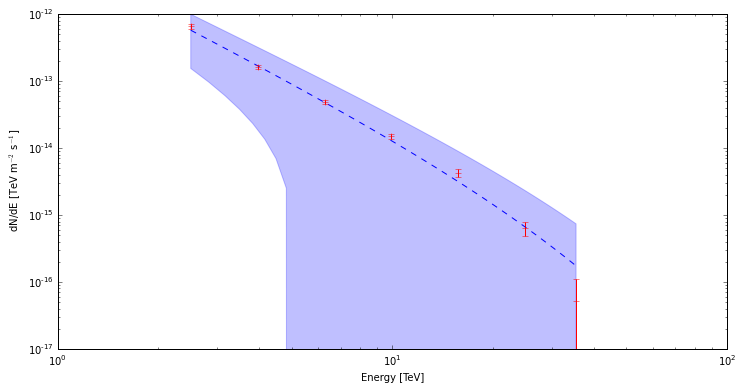

In [14]:
power = 0.
plotPythonFit(V_Points_fine['col1'], V_Points_fine['col2'], V_Points_fine['col3'], "blue", "HESS", ECPL=True, E0=1.25)
plt.errorbar(V_Points_fine['col1'], V_Points_fine['col2'] * V_Points_fine['col1']**power, 
             yerr = V_Points_fine['col3'] * V_Points_fine['col1']**power,
            label = "VERITAS 2016 Paper", ls="", marker="+", color="red")
plt.ylim(ymin=1e-17)
plt.ylabel(r" dN/dE [TeV m$^{-2}$ s$^{-1}$]")


Combine 

In [26]:
# updated VEGAS points 
# highest energy bins 
VEGAS_Points = """
2.498 5.71e-09 4.03e-10
3.96 1.7e-09 1.08e-10
6.276 5.48e-10 4.15e-11
9.946 1.69e-10 1.69e-11
15.76 6.07e-11 7.63e-12
24.98 6.81e-12 2.67e-12
39.6 2.39e-13 7.91e-13 """

V_Points = astropy.io.ascii.read(VEGAS_Points)
# convert from m^-2 to cm^-2
V_Points['col2'] *= 1e-4 * erg2TeV
V_Points['col3'] *= 1e-4 * erg2TeV

V_Points


col1,col2,col3
float64,float64,float64
2.498,3.563901835e-13,2.51532826533e-14
3.96,1.06105658835e-13,6.74083009072e-15
6.276,3.42034712011e-14,2.59022637745e-15
9.946,1.05481507901e-14,1.05481507901e-15
15.76,3.78859617136e-15,4.76227162891e-16
24.98,4.25046786276e-16,1.66648299465e-16
39.6,1.49172073304e-17,4.93703389052e-17


In [36]:
Andy_Points = '''
2.813 3.44e-13 4.52e-14 
3.541 2.17e-13 2.43e-14
4.458 1.23e-13 1.37e-14
5.613 5.13e-14  7.4e-15
7.066 2.72e-14  4.3e-15
8.896 1.27e-14 2.48e-15
12.49  5.8e-15 8.86e-16
 19.8 1.44e-15 3.36e-16
31.39 1.22e-16 8.14e-17'''

A_Points = astropy.io.ascii.read(Andy_Points)
#A_Points['col2'] *= erg2TeV
#A_Points['col3'] *= erg2TeV

#A_Points


parameters:
[-26.70246008  -2.15662883  11.70791671]
covariance matrix
[[  9.62471330e-04   7.15355259e-04  -6.56259924e-02]
 [  7.15355259e-04   7.44671130e-04  -5.40581112e-02]
 [ -6.56259924e-02  -5.40581112e-02   5.79076641e+00]]
chi^2: 1.05253097649



/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


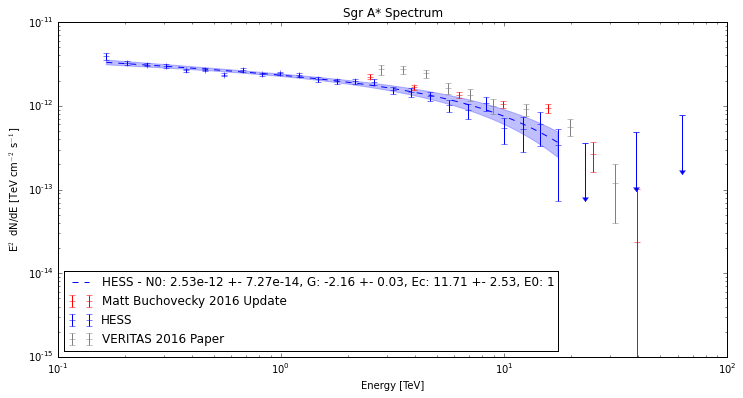

In [119]:
power = 2.

# my VEGAS points
#plotPythonFit(V_Points['col1'], V_Points['col2'], V_Points['col3'], "M2016", "red", ECPL=True, E0=1.0)
plt.errorbar(V_Points['col1'], V_Points['col2'] * V_Points['col1']**power, 
             yerr = V_Points['col3'] * V_Points['col1']**power,
             label = "Matt Buchovecky 2016 Update", ls="", marker="+", color="red")

# HESS points
plotPythonFit(H_energy[:-3], H_flux[:-3], (H_err_dwn[:-3],H_err_up[:-3]), 
              "blue", "HESS", ECPL=True)
plt.errorbar(H_energy[:-3], H_energy[:-3]**2*H_flux[:-3], 
             yerr=H_energy[:-3]**2*(H_err_dwn[:-3], H_err_up[:-3]), 
             marker="+", ls="", color="blue", label="HESS")
plt.errorbar(H_energy[-3:], H_energy[-3:]**2*H_flux[-3:], 
             yerr=(H_energy[-3:]**2*H_err_up[-3:], H_energy[-3:]**2*H_err_dwn[-3:]), 
             marker="_", ls="", uplims=True, color="blue")

# Andy's points 

plt.errorbar(A_Points['col1'], A_Points['col2'] * A_Points['col1']**power, 
             yerr = A_Points['col3'] * A_Points['col1']**power,
            label = "VERITAS 2016 Paper", ls="", marker="+", color="gray")

# plot format and save 
plt.title("Sgr A* Spectrum ")
plt.loglog(nonposy="clip")
plt.ylim(ymin=1e-15)
plt.legend(loc="best")
plt.xlabel("Energy [TeV]")
plt.ylabel(r"E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]")

plt.savefig(gc_dir+"/plots/spectra/SgrA_spectra_HESSoverlay_wAndy_ECPL.png")


parameters:
[-26.70246008  -2.15662883  11.70791671]
covariance matrix
[[  9.62471330e-04   7.15355259e-04  -6.56259924e-02]
 [  7.15355259e-04   7.44671130e-04  -5.40581112e-02]
 [ -6.56259924e-02  -5.40581112e-02   5.79076641e+00]]
chi^2: 1.05253097649



/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


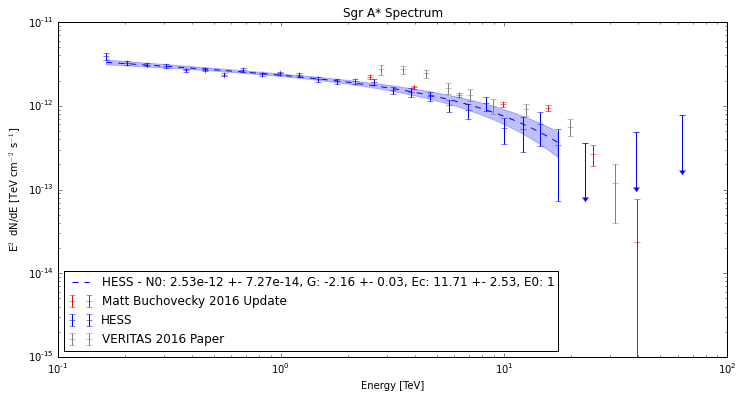

In [120]:
power = 2.
err_bar_red = sqrt(2) # projection for doubled dataset 

# my VEGAS points
#plotPythonFit(V_Points['col1'], V_Points['col2'], V_Points['col3'], "M2016", "red", ECPL=True, E0=1.0)
plt.errorbar(V_Points['col1'], V_Points['col2'] * V_Points['col1']**power, 
             yerr = V_Points['col3'] * V_Points['col1']**power / err_bar_red,
             label = "Matt Buchovecky 2016 Update", ls="", marker="+", color="red")

# HESS points
plotPythonFit(H_energy[:-3], H_flux[:-3], (H_err_dwn[:-3],H_err_up[:-3]), 
              "blue", "HESS", ECPL=True)
plt.errorbar(H_energy[:-3], H_energy[:-3]**2*H_flux[:-3], 
             yerr=H_energy[:-3]**2*(H_err_dwn[:-3], H_err_up[:-3]), 
             marker="+", ls="", color="blue", label="HESS")
plt.errorbar(H_energy[-3:], H_energy[-3:]**2*H_flux[-3:], 
             yerr=(H_energy[-3:]**2*H_err_up[-3:], H_energy[-3:]**2*H_err_dwn[-3:]), 
             marker="_", ls="", uplims=True, color="blue")

# Andy's points 

plt.errorbar(A_Points['col1'], A_Points['col2'] * A_Points['col1']**power, 
             yerr = A_Points['col3'] * A_Points['col1']**power,
            label = "VERITAS 2016 Paper", ls="", marker="+", color="gray")

# plot format and save 
plt.title("Sgr A* Spectrum ")
plt.loglog(nonposy="clip")
plt.ylim(ymin=1e-15)
plt.legend(loc="best")
plt.xlabel("Energy [TeV]")
plt.ylabel(r"E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]")

plt.savefig(gc_dir+"/plots/spectra/SgrA_spectra_HESSoverlay_wAndy_ECPL_projected.png")


<h3> Diffuse / Sgr B2 </h3>

In [100]:

diffuse_points = np.genfromtxt(gc_dir+"/spectralPoints/HESS_diffuse_spectrum_points_transpose.csv")
diffuse_points *= 1e3 # to go from cm^2 to m^2, and account for factor of 10 on plot 
diffuse_points[0] /= 1e3 

# not needed anymore 
diffuse_err_up = diffuse_points[2] - diffuse_points[1]
diffuse_err_down = diffuse_points[1] - diffuse_points[3]
diffuse_points[2] = diffuse_err_down
diffuse_points[3] = diffuse_err_up 

print(diffuse_points)

np.savetxt(home+"/Downloads/HESS_diffuse_spectrum_E2flux_TeV-m2.csv", diffuse_points, delimiter='\t')



[[  2.20850261e-01   2.64390118e-01   3.21969498e-01   3.90705786e-01
    4.84473212e-01   5.88240155e-01   7.14878255e-01   8.67923209e-01
    1.04270871e+00   1.26531342e+00   1.53481067e+00   1.86430999e+00
    2.28679801e+00   2.76885018e+00   3.36604263e+00   4.13734162e+00
    5.01772330e+00   6.83684663e+00   1.00255035e+01   1.43445565e+01
    2.20941010e+01   3.84653723e+01]
 [  2.79000000e-08   4.70000000e-08   2.79000000e-08   2.83000000e-08
    2.38000000e-08   2.21000000e-08   1.79000000e-08   1.68000000e-08
    1.66000000e-08   1.68000000e-08   1.81000000e-08   1.58000000e-08
    1.47000000e-08   2.08000000e-08   1.60000000e-08   1.09000000e-08
    1.20000000e-08   6.90000000e-09   1.33000000e-08   1.04000000e-08
    5.66000000e-09   2.97000000e-09]
 [ -2.09000000e-08  -8.90000000e-09  -5.70000000e-09  -4.50000000e-09
   -4.10000000e-09  -3.50000000e-09  -2.90000000e-09  -3.00000000e-09
   -2.40000000e-09  -2.70000000e-09  -2.70000000e-09  -3.20000000e-09
   -3.00000000e-

/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


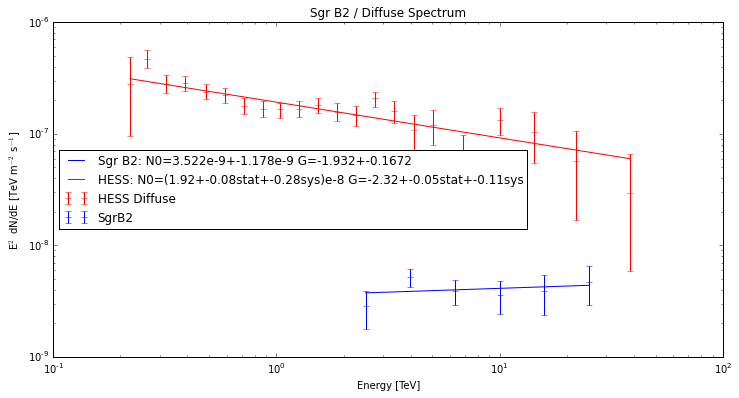

In [140]:
power = 2.
mult_factor = 10 # to put diffuse and Sgr B2 closer 

# transpose so each variable is a list
diffuse_points = np.genfromtxt(gc_dir+"/spectralPoints/HESS_diffuse_spectrum_E2flux_TeV-m2.csv")
diffuse_points *= mult_factor # to put it closer for comparison
diffuse_points[0] /= mult_factor 
# values are E^2 * flux 
SgrB2_points = np.genfromtxt(gc_dir+"/spectralPoints/SgrB2_spectral_flux_TeV-m2.txt")
#SgrB2_points *= 1e-4 # 
#SgrB2_points[:,0] *= 1e4 # don't want to adjust energy 
# values are just flux 

plt.errorbar(diffuse_points[0], diffuse_points[1]*diffuse_points[0]**(power-2.), 
             yerr=(diffuse_points[2]*diffuse_points[0]**(power-2.), 
                   diffuse_points[3]*diffuse_points[0]**(power-2.)), 
             marker='+', ls='', color='red', label='HESS Diffuse')
plt.errorbar(SgrB2_points[:,0], SgrB2_points[:,1]*SgrB2_points[:,0]**power, 
             yerr=SgrB2_points[:,2]*SgrB2_points[:,0]**power, 
             marker='_', ls='', color='blue', label='SgrB2')

E_SgrB2 = np.linspace(SgrB2_points[0,0], SgrB2_points[-1,0], 100)
flux_SgrB2 = 3.522e-9 * np.power(E_SgrB2, -1.932+power)
plt.plot(E_SgrB2, flux_SgrB2, color='blue', ls='-', marker='', 
         label="Sgr B2: N0=3.522e-9+-1.178e-9 G=-1.932+-0.1672")

E_diffuse = np.linspace(diffuse_points[0,0], diffuse_points[0,-1], 100)
flux_diffuse = 1.92e-8 * np.power(E_diffuse, -2.32+power)
plt.plot(E_diffuse, flux_diffuse*mult_factor, color='red', ls='-', marker='', 
         label="HESS: N0=(1.92+-0.08stat+-0.28sys)e-8 G=-2.32+-0.05stat+-0.11sys")


plt.title("Sgr B2 / Diffuse Spectrum")
plt.loglog()
#plt.ylim(ymin=3e-14)
plt.legend(loc="best")
plt.xlabel("Energy [TeV]")
plt.ylabel(r"E$^2$ dN/dE [TeV m$^{-2}$ s$^{-1}$]")

plt.savefig(gc_dir+"/plots/spectra/SgrB2_diffuse_spectra_HESSoverlay.png")


In [139]:
plt.plot?

<h2>G0.9+0.1</h2>

    col1      col2     col3     col4  
----------- -------- -------- --------
0.219663387 2.32e-11 3.17e-11  1.5e-11
0.366471541 8.03e-12 9.39e-12 6.52e-12
0.650552926 2.26e-12 2.64e-12  1.9e-12
1.164773919  6.7e-13 7.96e-13 5.63e-13
2.071088959 1.22e-13 1.64e-13 8.35e-14
3.886862492 1.52e-14 2.89e-14 4.38e-15
6.086655929 9.03e-15 1.49e-14 3.31e-15
parameters:
[-28.01447399  -2.45041611]
covariance matrix
[[ 122.26163602    3.05257531]
 [   3.05257531   95.07777031]]
0.92310580161
parameters:
[-27.96718132  -2.30684431]
covariance matrix
[[ 1904.58981605  -938.04775243]
 [ -938.04775243   523.04529769]]
0.0563942253789


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


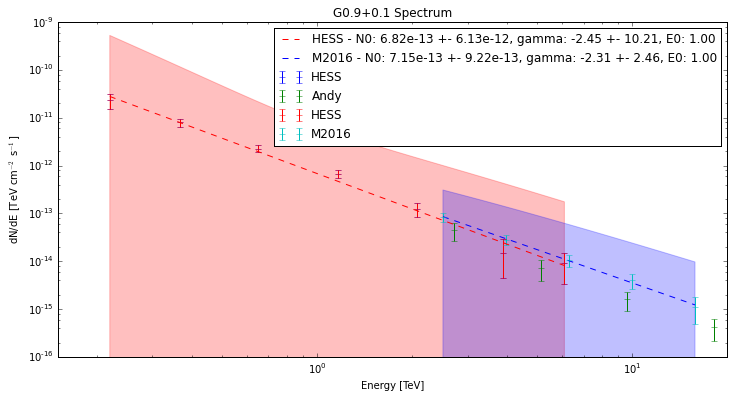

In [169]:
power = 0.
# all energies in TeV 
G09_points_M2016 = astropy.io.ascii.read(gc_dir+"/spectralPoints/G09+01_allOff_flux_TeV-m2.txt")
# need to fix HESS points, to give actual size of error bars 
G09_points_HESS = astropy.io.ascii.read(gc_dir+"/spectralPoints/G09+01_HESS_2005_flux_TeV-cm2.csv")
G09_points_Andy = astropy.io.ascii.read(gc_dir+"spectralPoints/G09+01_Andy_email_flux_m2.txt")
#G09_points_Andy = astropy.io.ascii.read(gc_dir+"spectralPoints/G09+01_Andy_spectral_points_E2-ergs.txt")


# convert m^-2 to cm^-2 
G09_points_M2016['col2'] *= 1e-4
G09_points_M2016['col3'] *= 1e-4

print(G09_points_HESS)

#plt.errorbar(G09_points_M2016['col1'], G09_points_M2016['col2'], G09_points_M2016['col3'], 
#            label='M2016', ls='', marker='_')
plt.errorbar(G09_points_HESS['col1'], G09_points_HESS['col2'], 
             (G09_points_HESS['col2']-G09_points_HESS['col4'], G09_points_HESS['col3']-G09_points_HESS['col2']),
            label="HESS", ls='', marker='_')
plt.errorbar(G09_points_Andy['col1'], G09_points_Andy['col2']*1e-4, G09_points_Andy['col3']*1e-4,
            label="Andy", ls='', marker='_')
#plt.errorbar(G09_points_Andy['col1'], G09_points_Andy['col2']/erg2TeV, G09_points_Andy['col3']/erg2TeV, label="Andy", ls='')

plotPythonFit(G09_points_HESS['col1'], G09_points_HESS['col2'], 
             (G09_points_HESS['col2']-G09_points_HESS['col4'], G09_points_HESS['col3']-G09_points_HESS['col2']), 
              name="HESS", color='red')
plotPythonFit(G09_points_M2016['col1'], G09_points_M2016['col2'], 
              G09_points_M2016['col3'], 
              name="M2016", color='blue')


plt.title("G0.9+0.1 Spectrum ")
plt.loglog(nonposy="clip")
plt.legend(loc="best")
#plt.xlabel("Energy [TeV]")
plt.xlim(xmin=0.15, xmax=20)
# think this is just dN/dE
plt.ylabel(r"dN/dE [TeV cm$^{-2}$ s$^{-1}$]")

plt.savefig(gc_dir+"/plots/spectra/G09_spectra_HESSoverlay_wAndy.png")



parameters:
[-28.15383586  -2.58952104]
covariance matrix
[[ 1433.68340047  -619.74404165]
 [ -619.74404165   309.13835126]]
0.534023119906


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


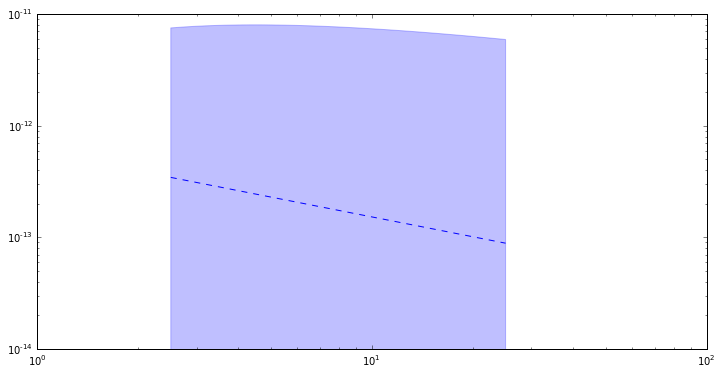

In [23]:
plotPythonFit(G09_points_M2016['col1'], G09_points_M2016['col2'], G09_points_M2016['col3'], 
                'blue', name='M2016')


<h2> Disp 5t / LZA / Crab Validation

/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


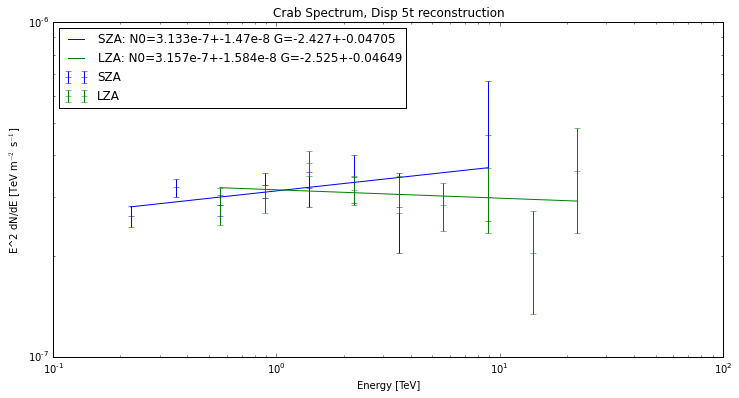

In [158]:
power = 2.5
plt.ylabel(r"E^2 dN/dE [TeV m$^{-2}$ s$^{-1}$]")

crab_dir = home + "/Dropbox/VEGAS/Crab"
sza_points = np.genfromtxt(crab_dir+"/spectralPoints/spectral_points_Crab_SZA.txt")
lza_points = np.genfromtxt(crab_dir+"/spectralPoints/spectral_points_Crab_LZA.txt")
# :,0 gives energy - then flux, error 

plt.errorbar(sza_points[:,0],
                 sza_points[:,1]*sza_points[:,0]**power, 
                 sza_points[:,2]*sza_points[:,0]**power, 
                 label='SZA', ls='', color='blue', marker='_')
plt.errorbar(lza_points[:,0], 
                 lza_points[:,1]*lza_points[:,0]**power, 
                 lza_points[:,2]*lza_points[:,0]**power, 
                 label='LZA', ls='', color='green', marker='_')
plt.title("Crab Spectrum, Disp 5t reconstruction")
plt.xlabel("Energy [TeV]")
#plt.xlim(0.9*sza_points[0,0], 1.1*lza_points[-1,0])
plt.ylabel(r"E^2 dN/dE [TeV m$^{-2}$ s$^{-1}$]")
plt.loglog()

E_sza = np.linspace(sza_points[0,0], sza_points[-1,0], 100)
E_lza = np.linspace(lza_points[0,0], lza_points[-1,0], 100)

# fit parameters from VEGAS output 
flux_sza = 3.133e-7 * np.power(E_sza, -2.427+power)
flux_lza = 3.157e-7 * np.power(E_lza, -2.525+power)
plt.plot(E_sza, flux_sza, color='blue', ls='-', marker='', label="SZA: N0=3.133e-7+-1.47e-8 G=-2.427+-0.04705")
plt.plot(E_lza, flux_lza, color='green', ls='-', marker='', label="LZA: N0=3.157e-7+-1.584e-8 G=-2.525+-0.04649")
# add upper limit 

plt.legend(loc="best")
plt.savefig(home+"/Dropbox/VEGAS/Crab/plots/Crab_V6_disp5t_SZAvLZA_spectrum_E"+str(power)+"dNdE.png")


In [107]:
print(sza_points)

[[  2.23000000e-01   1.12000000e-05   8.17000000e-07]
 [  3.53500000e-01   4.32000000e-06   2.68000000e-07]
 [  5.60200000e-01   1.21000000e-06   9.11000000e-08]
 [  8.87900000e-01   4.39000000e-07   3.87000000e-08]
 [  1.40700000e+00   1.36000000e-07   1.64000000e-08]
 [  2.23000000e+00   4.65000000e-08   7.69000000e-09]
 [  3.53500000e+00   1.19000000e-08   3.22000000e-09]
 [  8.87900000e+00   1.96000000e-09   8.79000000e-10]]
